In [3]:
"""
Preamble for most code and jupyter notebooks
@author: tobinsouth
@notebook date: 16 Nov 2021
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import math, string, re, pickle, json, os, sys, datetime, itertools
from collections import Counter
from tqdm import tqdm

# Set panda's options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 120)

# Better graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-poster')

In [4]:
reponse = pd.read_csv('../data/reponse_var.csv')
reponse['tratamiento'] = reponse['tratamiento'].map({1: 'Control', 2: 'Math tutoring', 4: 'Math tutoring', 2: 'Math + emotion learning tutoring'})
# reponse = reponse[~reponse['file'].isna()]

# Processing the transcriptions

In [5]:
import glob
tokens_by_lesson = {}
for file in glob.glob('../data/transcripts/*.txt'):

    # Read text file
    with open(file, 'r') as f:
        text = f.read()

    lesson_tokens = text.split(" ")

    tokens_by_lesson[file.split('/')[-1].split('.')[0]] = lesson_tokens
    
    # with open(file) as f:
    #     lesson = json.load(f)

    #     # Some files are empty
    #     if len(lesson) == 0:
    #         continue

    #     lesson_tokens  = [ ]
    #     for t in lesson['results']:
    #         words = t['alternatives'][0]['words']
    #         for word in words:
    #             lesson_tokens.append((word['word'], word.get('speakerTag', -1)))

    #     tokens_by_lesson[file.split('/')[-1].split('.')[0]] = lesson_tokens
            
    



In [6]:
lengths = {lesson:len(lesson_tokens) for lesson, lesson_tokens in tokens_by_lesson.items()}

In [7]:
import spacy
nlp = spacy.load("es_core_news_sm")
docs = {lesson:nlp(" ".join([v for v in lesson_tokens]).lower()) for lesson, lesson_tokens in tokens_by_lesson.items()}

2021-12-07 02:32:25.342044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/torch/install/lib:/usr/local/cuda/lib64
2021-12-07 02:32:25.342074: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
person_entity_counts = {lesson:len([ent for ent in doc.ents if ent.label_ == 'PER']) for lesson, doc in docs.items()}
pronoun_counts = {lesson:len([w for w in doc if w.pos_ in ['PRON', 'PROPN']]) for lesson, doc in docs.items()}
numeric_counts = {lesson:len([t for t in doc.text.split() if t.isnumeric()]) for lesson, doc in docs.items()}
non_stop_counts = {lesson:Counter([t.text for t in doc if t.is_stop == False and t.is_punct == False]) for lesson, doc in docs.items()}

In [9]:
word_sum = lambda x: sum([c for t,c in x])
common_ratio = {lesson: word_sum(non_stop.most_common(30))/word_sum(non_stop.most_common()) for lesson, non_stop in non_stop_counts.items() if len(non_stop) > 0}

## Attaching normal transcripts imputed variables to response variables

In [10]:
reponse['file'] = reponse['file'].str.replace('.mp4', '')

/tmp/ipykernel_394174/114226192.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  reponse['file'] = reponse['file'].str.replace('.mp4', '')


In [11]:
reponse['lengths']= reponse['file'].map(lengths)
reponse['person_entity_counts']= reponse['file'].map(person_entity_counts)
reponse['pronoun_counts']= reponse['file'].map(pronoun_counts)
reponse['numeric_counts']= reponse['file'].map(numeric_counts)
reponse['common_ratio'] = reponse['file'].map(common_ratio)

## Attaching diarized results to the response variables

In [12]:
diarized_results = pd.read_csv("../data/diarized_results.csv")
data = reponse.set_index('file').join(diarized_results.set_index('file'), how='left')


# Regressions

In [13]:
df = data[~data['lengths'].isna()]
# df = df[df['lengths'] > 100]

In [14]:
# df[lengths	person_entity_counts	pronoun_counts	numeric_counts	common_ratio	number_of_speakers	speaking_inequality	tutor_person_entity_counts	tutor_pronoun_counts	tutor_numeric_counts	tutor_common_ratio]

In [44]:
import statsmodels.formula.api as smf
df['Clengths'] = ( df['lengths'] - df['lengths'].mean() ) / df['lengths'].std()
df['Cperson_entity_counts'] = ( df['person_entity_counts'] - df['person_entity_counts'].mean() ) / df['person_entity_counts'].std()
df['Cpronoun_counts'] = ( df['pronoun_counts'] - df['pronoun_counts'].mean() ) / df['pronoun_counts'].std()
df['Ccommon_ratio'] = ( df['common_ratio'] - df['common_ratio'].mean() ) / df['common_ratio'].std()

# OLS on ChangeMathScore with inputed variables
model = smf.ols(formula='ChangeMathScore ~ Clengths+ Cperson_entity_counts + Cpronoun_counts + Ccommon_ratio', data=df).fit()
model.summary()

/tmp/ipykernel_394174/383960749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Clengths'] = ( df['lengths'] - df['lengths'].mean() ) / df['lengths'].std()
/tmp/ipykernel_394174/383960749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cperson_entity_counts'] = ( df['person_entity_counts'] - df['person_entity_counts'].mean() ) / df['person_entity_counts'].std()
/tmp/ipykernel_394174/383960749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ChangeMathScore   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.001042
Date:                Tue, 07 Dec 2021   Prob (F-statistic):              0.974
Time:                        02:59:56   Log-Likelihood:                -445.80
No. Observations:                 281   AIC:                             895.6
Df Residuals:                     279   BIC:                             902.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0667      0.072     -0.931      0.353      -0.208       0.074
Clengths      -0.0021      0.066     -0.032      0.974      -0.131       0.127
==============================================================================
Omnibus:                       22.560   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.246
Skew:                          -0.630   Prob(JB):                     1.21e-06
Kurtosis:                       3.861   Cond. No.                         1.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

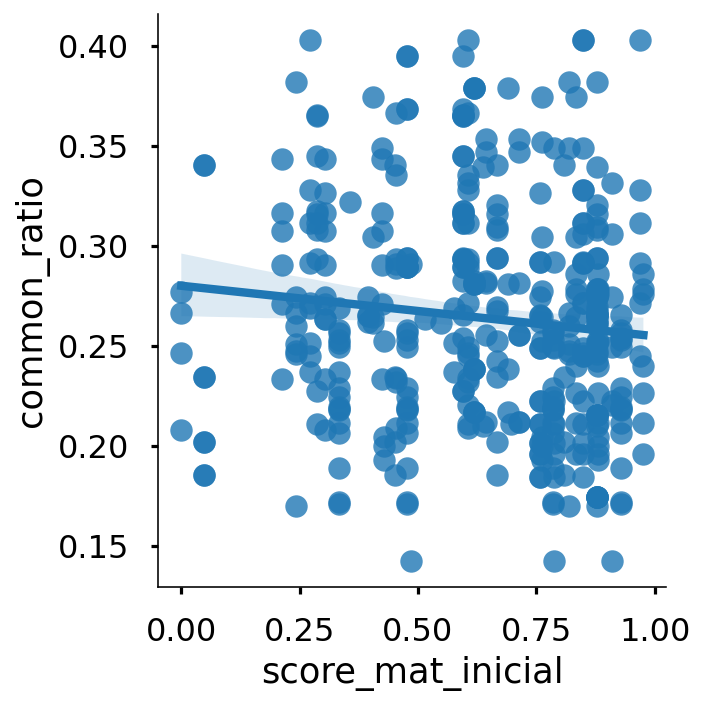

In [22]:
sns.lmplot(data=df, x='score_mat_inicial', y='common_ratio')

In [29]:
model = smf.ols(formula='score_mat_inicial ~ lengths + person_entity_counts + pronoun_counts + common_ratio', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      score_mat_inicial   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.619
Date:                Tue, 07 Dec 2021   Prob (F-statistic):            0.00117
Time:                        02:45:05   Log-Likelihood:                 14.304
No. Observations:                 411   AIC:                            -18.61
Df Residuals:                     406   BIC:                             1.484
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.0153      0.098     10.364      0.000       0.823       1.208
lengths               3.902e-05   2.67e-05      1.462      0.145   -1.35e-05    9.15e-05
person_entity_counts    -0.0004      0.001     -0.336      0.737      -0.003       0.002
pronoun_counts          -0.0005      0.000     -2.186      0.029      -0.001   -4.61e-05
common_ratio            -0.9754      0.288     -3.382      0.001      -1.542      -0.409
==============================================================================
Omnibus:                       25.092   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.522
Skew:                          -0.547   Prob(JB):                     4.73e-06
Kurtosis:                       2.517   Cond. No.                     1.38e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [289]:
# df.melt(id_vars=['tratamiento'], value_vars=['lengths', 'person_entity_counts', 'pronoun_counts', 'numeric_counts', 'common_ratio'])

In [290]:
df.groupby('tratamiento')['lengths','person_entity_counts','pronoun_counts','numeric_counts','common_ratio'].mean()

/var/folders/53/w69kfwk15djb4p1k1nzr5dzr0000gn/T/ipykernel_82367/350697932.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('tratamiento')['lengths','person_entity_counts','pronoun_counts','numeric_counts','common_ratio'].mean()


,lengths,person_entity_counts,pronoun_counts,numeric_counts,common_ratio
tratamiento,,,,,
Math + emotion learning tutoring,5089.000000,15.416667,600.666667,263.000000,0.698219
Math tutoring,5093.684211,22.245614,608.035088,268.350877,0.691439


In [291]:
df.groupby('tratamiento')['lengths','person_entity_counts','pronoun_counts','numeric_counts','common_ratio'].std()

/var/folders/53/w69kfwk15djb4p1k1nzr5dzr0000gn/T/ipykernel_82367/2938289726.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('tratamiento')['lengths','person_entity_counts','pronoun_counts','numeric_counts','common_ratio'].std()


,lengths,person_entity_counts,pronoun_counts,numeric_counts,common_ratio
tratamiento,,,,,
Math + emotion learning tutoring,3087.890660,7.959652,362.430767,201.206362,0.079161
Math tutoring,2339.979298,18.635872,294.321251,142.732078,0.089405


In [31]:
dfD = data[~data['speaking_inequality'].isna()]

In [32]:
dfD.columns

Index(['ChangeMathScore', 'score_mat_inicial', 'score_mat_final',
       'tel_mas_confiable', 'MathScore', 'std_mat_inicial', 'tratamiento',
       'prefijo', 'prefijo.1', 'lengths', 'person_entity_counts',
       'pronoun_counts', 'numeric_counts', 'common_ratio',
       'number_of_speakers', 'speaking_inequality',
       'tutor_person_entity_counts', 'tutor_pronoun_counts',
       'tutor_numeric_counts', 'tutor_common_ratio'],
      dtype='object')

In [48]:
dfD['Clengths'] = ( dfD['lengths'] - dfD['lengths'].mean() ) / dfD['lengths'].std()
dfD['Cspeaking_inequality'] = ( dfD['speaking_inequality'] - dfD['speaking_inequality'].mean() ) / dfD['speaking_inequality'].std()
dfD['Ctutor_person_entity_counts'] = ( dfD['tutor_person_entity_counts'] - dfD['tutor_person_entity_counts'].mean() ) / dfD['tutor_person_entity_counts'].std()
dfD['Ctutor_pronoun_counts'] = ( dfD['tutor_pronoun_counts'] - dfD['tutor_pronoun_counts'].mean() ) / dfD['tutor_pronoun_counts'].std()


model = smf.ols(formula='ChangeMathScore ~ Clengths + number_of_speakers + speaking_inequality + tutor_person_entity_counts + tutor_pronoun_counts -1', data=dfD).fit()
model.summary()

/tmp/ipykernel_394174/679778440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfD['Clengths'] = ( dfD['lengths'] - dfD['lengths'].mean() ) / dfD['lengths'].std()
/tmp/ipykernel_394174/679778440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfD['Cspeaking_inequality'] = ( dfD['speaking_inequality'] - dfD['speaking_inequality'].mean() ) / dfD['speaking_inequality'].std()
/tmp/ipykernel_394174/679778440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        ChangeMathScore   R-squared (uncentered):                   0.057
Model:                            OLS   Adj. R-squared (uncentered):             -0.018
Method:                 Least Squares   F-statistic:                             0.7589
Date:                Tue, 07 Dec 2021   Prob (F-statistic):                       0.583
Time:                        03:05:39   Log-Likelihood:                         -107.70
No. Observations:                  68   AIC:                                      225.4
Df Residuals:                      63   BIC:                                      236.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Clengths                      -0.0033      0.169     -0.019      0.985      -0.341       0.335
number_of_speakers            -0.0375      0.112     -0.335      0.738      -0.261       0.186
speaking_inequality            0.4881      0.772      0.632      0.530      -1.055       2.032
tutor_person_entity_counts     0.0240      0.017      1.379      0.173      -0.011       0.059
tutor_pronoun_counts          -0.0013      0.002     -0.821      0.415      -0.004       0.002
==============================================================================
Omnibus:                        2.477   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.697
Skew:                          -0.325   Prob(JB):                        0.428
Kurtosis:                       3.420   Cond. No.                     1.88e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [238]:
model = smf.ols(formula='ChangeMathScore ~ lengths', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ChangeMathScore   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6.462
Date:                Wed, 17 Nov 2021   Prob (F-statistic):             0.0128
Time:                        18:10:18   Log-Likelihood:                -127.39
No. Observations:                  87   AIC:                             258.8
Df Residuals:                      85   BIC:                             263.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3966      0.256     -1.549      0.125      -0.906       0.113
lengths        0.0001   4.68e-05      2.542      0.013    2.59e-05       0.000
==============================================================================
Omnibus:                        4.952   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                5.387
Skew:                          -0.269   Prob(JB):                       0.0676
Kurtosis:                       4.094   Cond. No.                     1.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

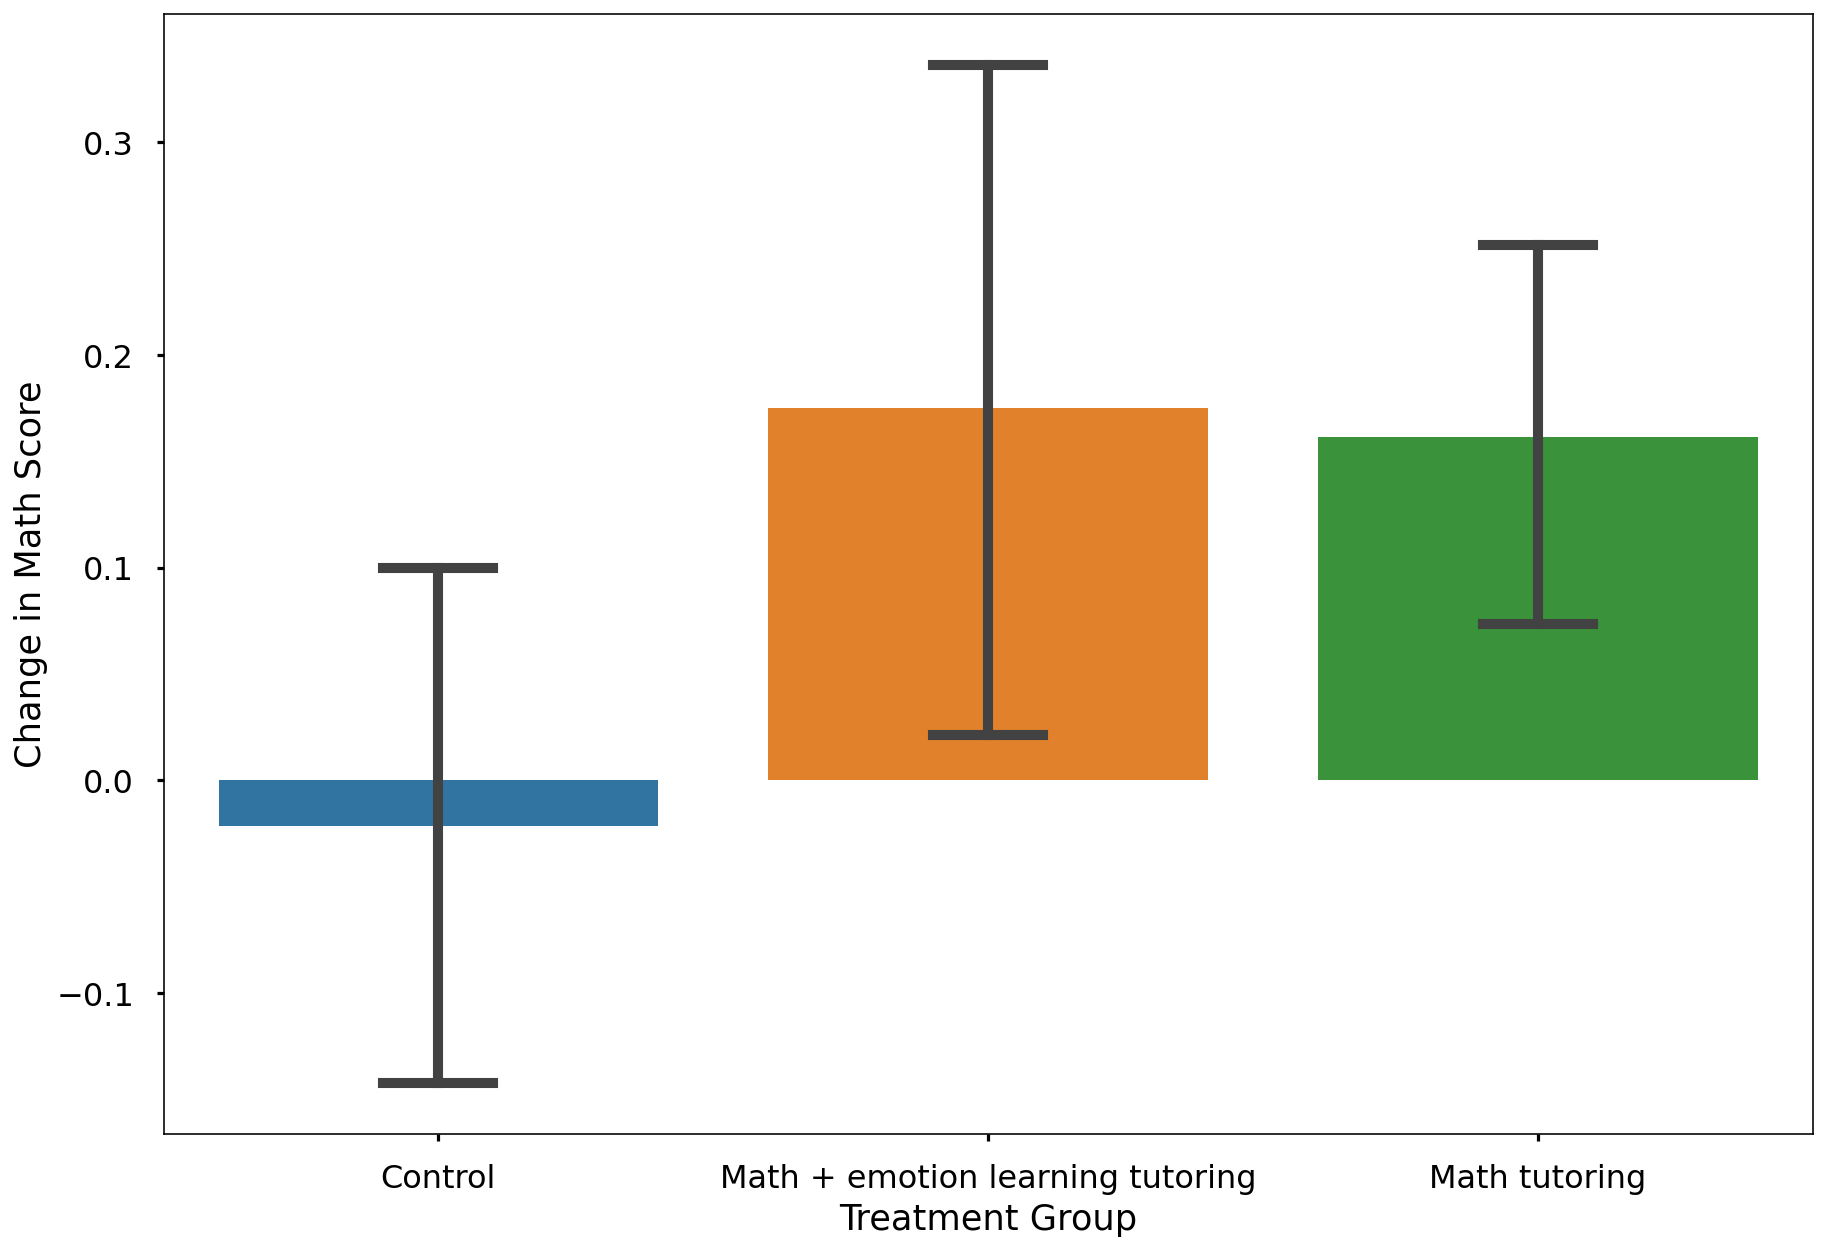

In [281]:
sns.barplot(x='tratamiento', y='ChangeMathScore', data=reponse, ci=90, capsize=.2)
plt.ylabel('Change in Math Score')
plt.xlabel('Treatment Group')
plt.tight_layout()
plt.savefig('ChangeMathScore_by_treatment.png', dpi = 500)

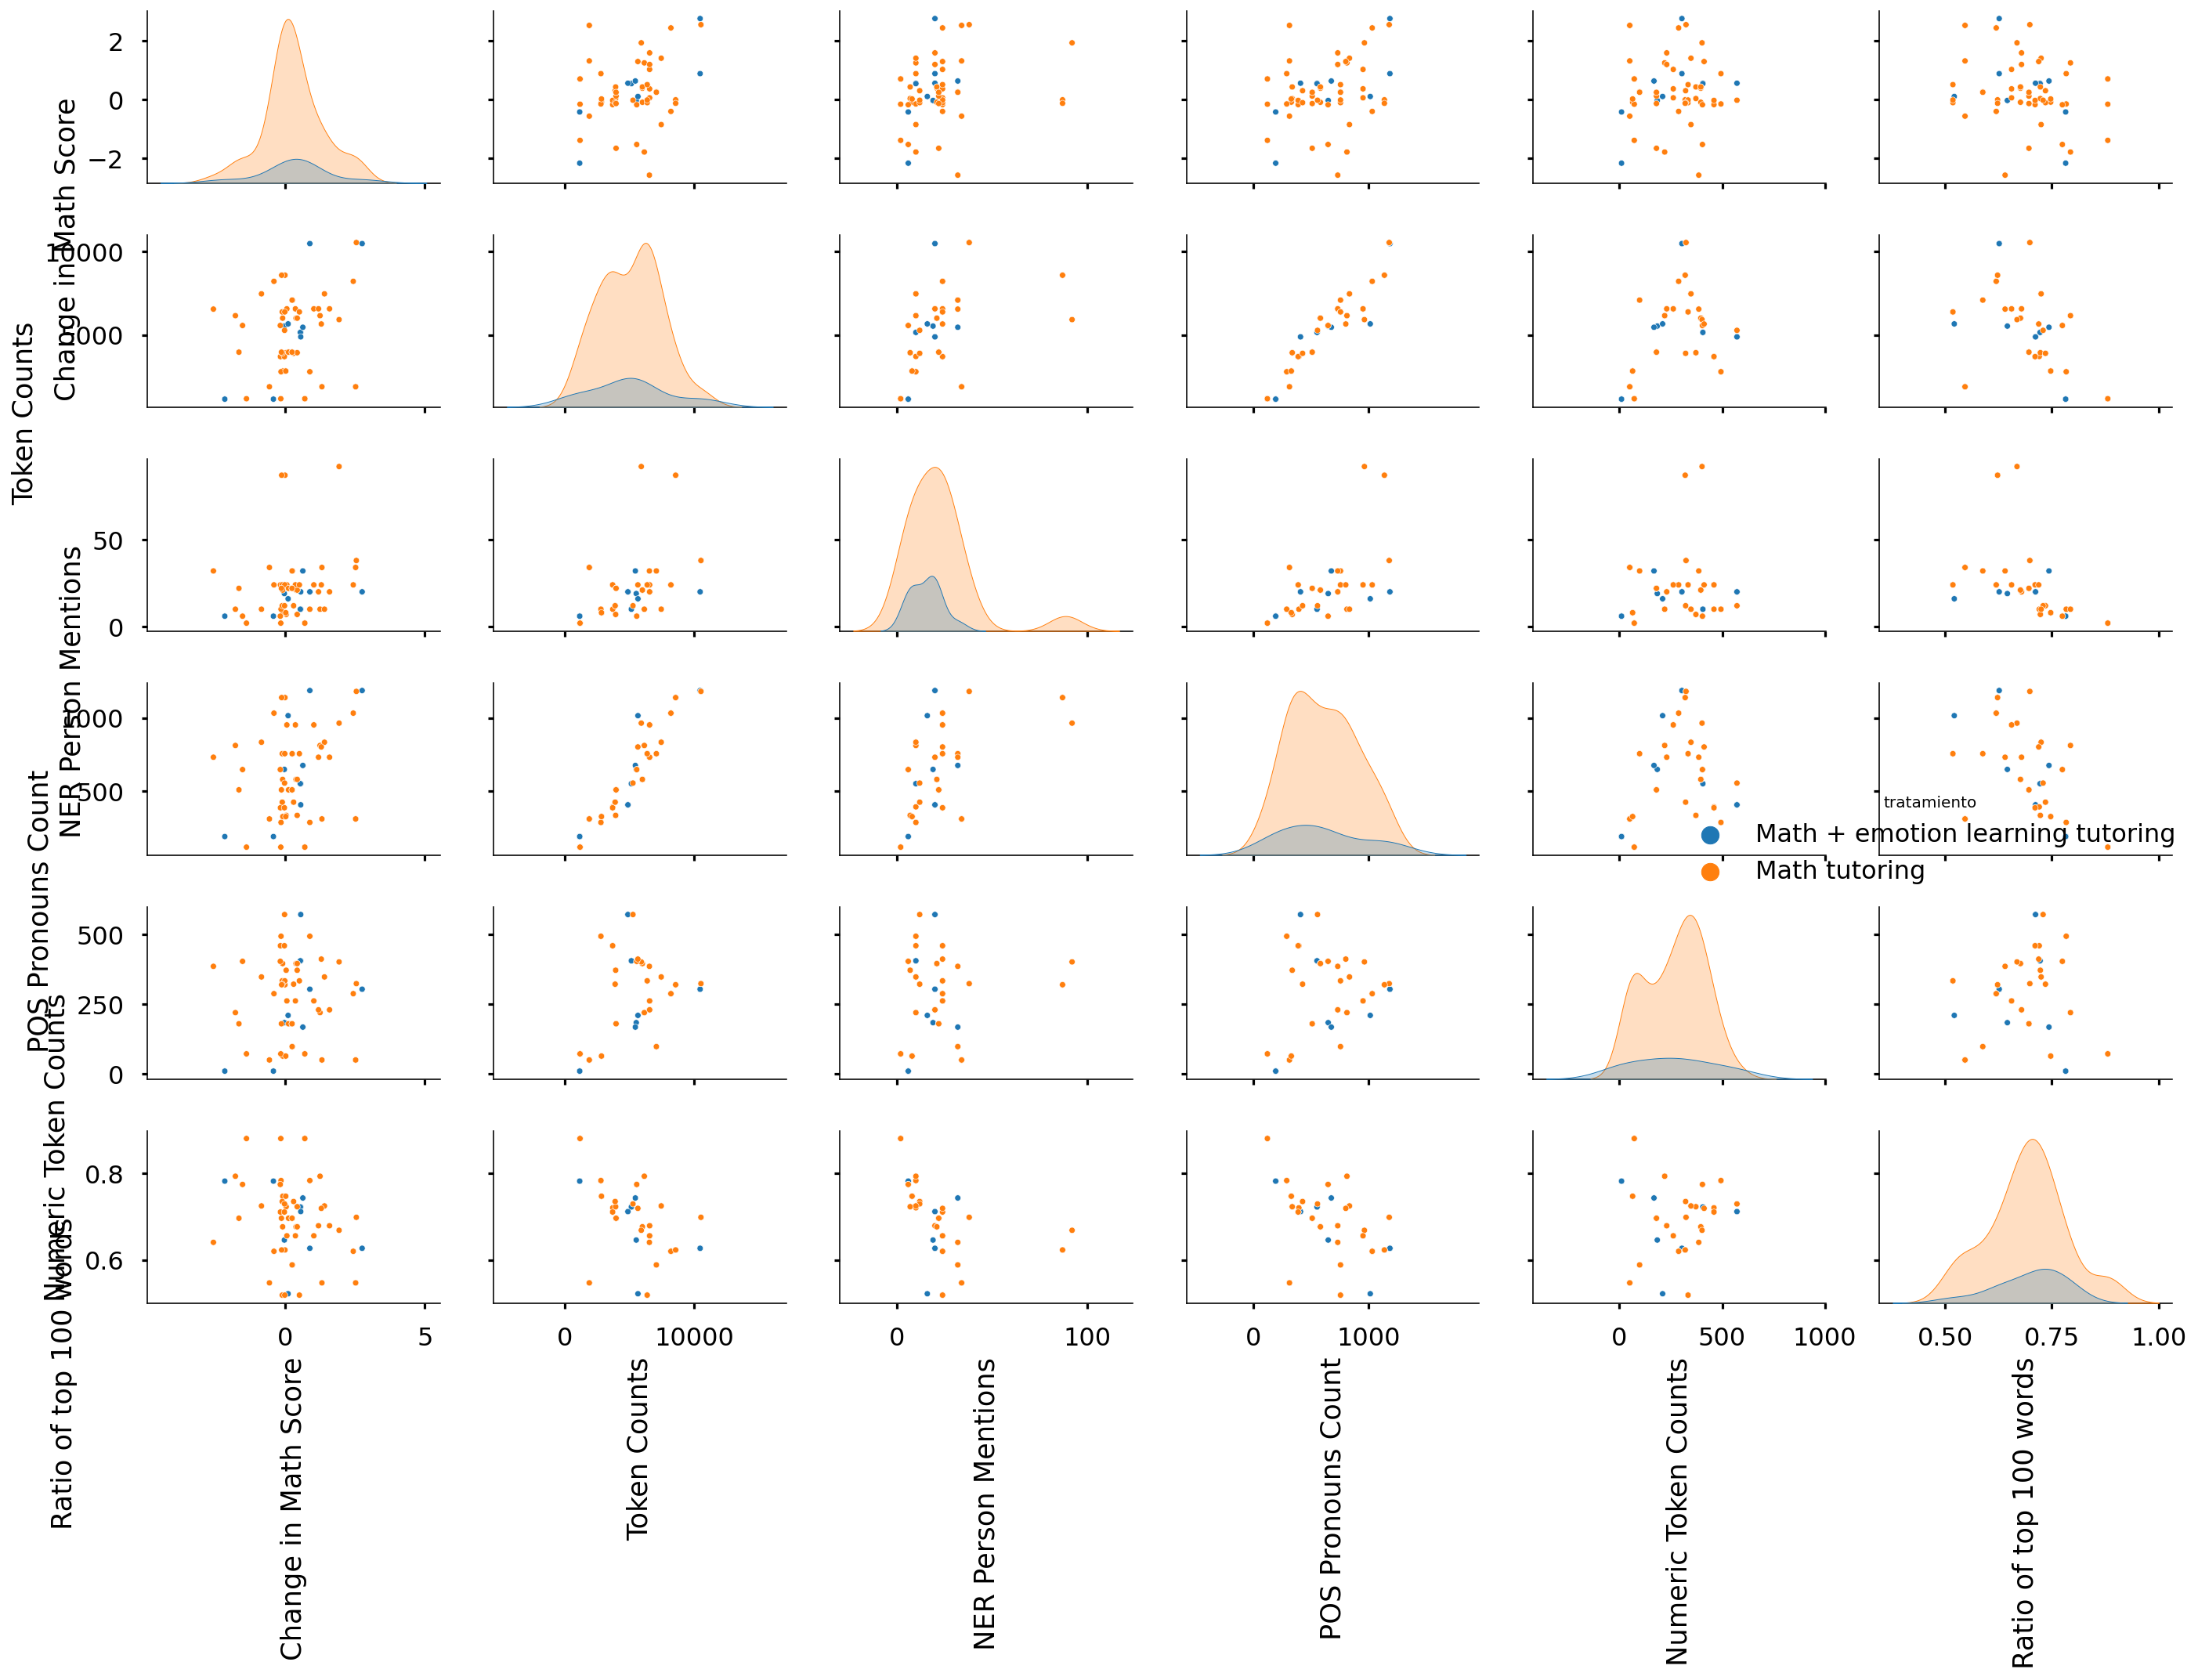

In [280]:
dd_ = df.rename(axis=1, mapper={'ChangeMathScore':  'Change in Math Score', 'lengths': 'Token Counts', 'person_entity_counts':'NER Person Mentions', 'pronoun_counts': 'POS Pronouns Count', 'numeric_counts': 'Numeric Token Counts', 'common_ratio': 'Ratio of top 100 words'})
g = sns.pairplot(dd_, hue='tratamiento', plot_kws={'s':15, 'lw':0}, vars=['Change in Math Score', 'Token Counts', 'NER Person Mentions', 'POS Pronouns Count', 'Numeric Token Counts', 'Ratio of top 100 words'])
for ax in g.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

# g._legend.set_bbox_to_anchor((0.25, 0.05))
plt.tight_layout()
plt.savefig('pairplot.png', dpi = 500)